In [1]:
# Dependencies
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Define URL parameters
league_id = "730129"
year = 2022
week = 1

In [3]:
# Define cookie parameters - hide these later
espn_s2 = "AEBf5XsEs36YHPGt6sEzt3fhCIJToMk2O5vXaS2O2MEFLojB997aAG9DTnZER2NK2nssy0f2PqpXx%2BiTa3QKjlM1HBK7jF77svlSafhr%2BToZu4Dh%2B1dqtOoHTqQ3b5FnG1hRoBY0KDo3GfceRrICzAL7Mj9pRpsM6u3iDIC7Wn5PoEOYgFdUOnUnb8EMeHQ6s33caLGvUzTDarjGPm0k4opBXpbCT8m%2BGxUtBEqoVJY%2FSHxNw21jq2o7JQ70%2BJhRmf%2BeEx%2BWLaUE1tTwcbzmQFDzdLg2f6GXB14EFn4G7YuQHw%3D%3D"
swid = "{E876EBB1-2C60-45B7-94AA-1611AD9AC4A3}"

In [4]:
# Define the URL with our parameters
url = f"https://fantasy.espn.com/apis/v3/games/ffl/seasons/{year}/segments/0/leagues/{league_id}"
#'http://games.espn.com/ffl/api/v2/scoreboard'

In [5]:
# Pull team and matchup data from the URL
matchup_response = requests.get(url, 
                                params={"leagueId" : league_id,
                                       "seasonId" : year,
                                       "matchupPeriodId" : week,
                                       "view": "mMatchup"}, 
                                verify=False,
                               cookies={"swid" : swid,
                                       "espn_s2" : espn_s2})

team_response = requests.get(url, 
                                params={"leagueId" : league_id,
                                       "seasonId" : year,
                                       "matchupPeriodId" : week,
                                       "view": "mTeam"}, 
                                verify=False,
                               cookies={"swid" : swid,
                                       "espn_s2" : espn_s2},)

C:\Users\bryantim\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fantasy.espn.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\bryantim\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fantasy.espn.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [6]:
# Transform the response into a json
matchup_json = matchup_response.json()
team_json = team_response.json()

In [7]:
# Transform both of the json outputs into DataFrames
matchup_df = pd.json_normalize(matchup_json['schedule'])
team_df = pd.json_normalize(team_json['teams'])

In [8]:
# Define the column names needed
matchup_column_names = {
    'matchupPeriodId':'Week', 
    'away.teamId':'Team1', 
    'away.totalPoints':'Score1',
    'home.teamId':'Team2', 
    'home.totalPoints':'Score2',
}

team_column_names = {
    'id':'id',
    'location':'Name1',
    'nickname':'Name2'
}

# Reindex based on column names defined above
matchup_df = matchup_df.reindex(columns=matchup_column_names).rename(columns=matchup_column_names)
team_df = team_df.reindex(columns=team_column_names).rename(columns=team_column_names)

In [9]:
# Add a new column for regular/playoff game based on week number
matchup_df['Type'] = ['Regular' if week<=13 else 'Playoff' for week in matchup_df['Week']]

# Concatenate the two name columns
team_df['Name'] = team_df['Name1'] + ' ' + team_df['Name2']

# Drop all columns except id and Name
team_df = team_df.filter(['id', 'Name'])

In [10]:
# (1) Rename Team1 column to id
matchup_df = matchup_df.rename(columns={"Team1":"id"})

# (1) Merge DataFrames to get team names instead of ids and rename Name column to Name1
matchup_df = matchup_df.merge(team_df, on=['id'], how='left')
matchup_df = matchup_df.rename(columns={'Name':'Name1'})

# (1) Drop the id column and reorder columns
matchup_df = matchup_df[['Week', 'Name1', 'Score1', 'Team2', 'Score2', 'Type']]

In [11]:
# (2) Rename Team1 column to id
matchup_df = matchup_df.rename(columns={"Team2":"id"})

# (2) Merge DataFrames to get team names instead of ids and rename Name column to Name2
matchup_df = matchup_df.merge(team_df, on=['id'], how='left')
matchup_df = matchup_df.rename(columns={'Name':'Name2'})

# (2) Drop the id column and reorder columns
matchup_df = matchup_df[['Week', 'Name1', 'Score1', 'Name2', 'Score2', 'Type']]

In [12]:
# Get a look at the data
matchup_df

,Week,Name1,Score1,Name2,Score2,Type
0,1,Good Christian Men,100.74,Ill. Fantasy Football Team,152.70,Regular
1,1,The Christian McGashrey's,93.72,🍑 Etienne Szn,96.78,Regular
2,1,Hurts Donut?,155.28,gabby petito,127.82,Regular
3,1,Ha-Ha Hillary Loves Clinton D,137.11,2 Gurlz 1 Kupp,150.51,Regular
4,1,Hangin with Hernandez,76.39,JJ's SKOLdiers,153.59,Regular
...,...,...,...,...,...,...
60,13,gabby petito,0.00,2 Gurlz 1 Kupp,0.00,Regular
61,13,🍑 Etienne Szn,0.00,Ha-Ha Hillary Loves Clinton D,0.00,Regular
62,13,JJ's SKOLdiers,0.00,Good Christian Men,0.00,Regular
63,13,Ill. Fantasy Football Team,0.00,The Christian McGashrey's,0.00,Regular


In [13]:
# Filter down to the week in question
week_matchup_df = matchup_df[matchup_df['Week'] == week]

# Define winning team column
conditions = [
    week_matchup_df['Score1'] > week_matchup_df['Score2'],
    week_matchup_df['Score2'] > week_matchup_df['Score1']
]

values = [week_matchup_df['Name1'], week_matchup_df['Name2']]

week_matchup_df['WinningTeam'] = np.select(conditions, values)

week_matchup_df

C:\Users\bryantim\AppData\Local\Temp\ipykernel_22820\1723049436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_matchup_df['WinningTeam'] = np.select(conditions, values)


,Week,Name1,Score1,Name2,Score2,Type,WinningTeam
0,1,Good Christian Men,100.74,Ill. Fantasy Football Team,152.70,Regular,Ill. Fantasy Football Team
1,1,The Christian McGashrey's,93.72,🍑 Etienne Szn,96.78,Regular,🍑 Etienne Szn
2,1,Hurts Donut?,155.28,gabby petito,127.82,Regular,Hurts Donut?
3,1,Ha-Ha Hillary Loves Clinton D,137.11,2 Gurlz 1 Kupp,150.51,Regular,2 Gurlz 1 Kupp
4,1,Hangin with Hernandez,76.39,JJ's SKOLdiers,153.59,Regular,JJ's SKOLdiers


In [14]:
# Calculate average score for the week
average_score = (week_matchup_df['Score1'].sum() + week_matchup_df['Score2'].sum()) / 10

average_score

124.46399999999998

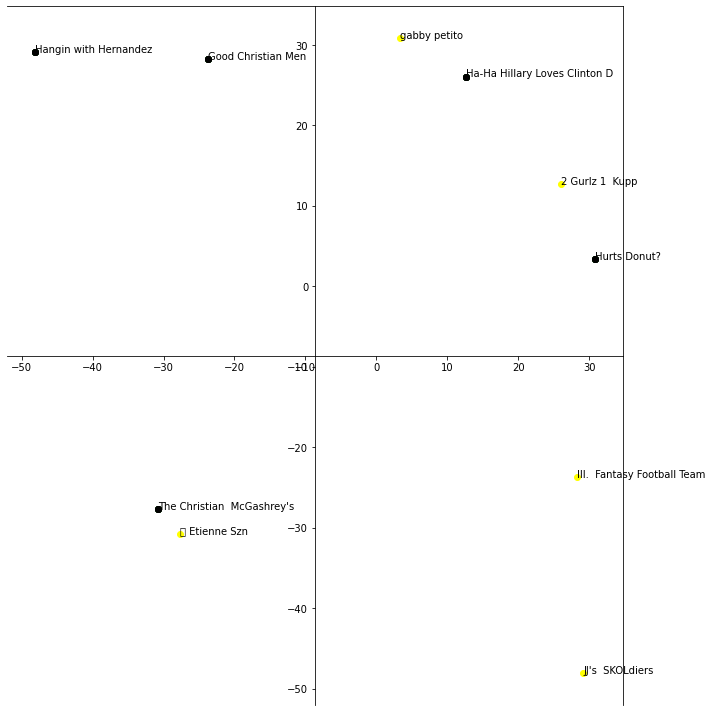

In [24]:
# Define plot size and autolayout
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

# Define the subplot
fig, ax = plt.subplots()

# Create marker dictionary based on win/loss


# Plot the away team data on the subplots
for team in range(0, len(week_matchup_df)):
    if week_matchup_df['Score1'][team] > week_matchup_df['Score2'][team]:
        ax.scatter(week_matchup_df['Score1'] - average_score, week_matchup_df['Score2'] - average_score, c='green')
    if week_matchup_df['Score1'][team] < week_matchup_df['Score2'][team]:
        ax.scatter(week_matchup_df['Score1'] - average_score, week_matchup_df['Score2'] - average_score, c='black')

# Loop through and annotate the away team names on the chart
for name in range(0, len(week_matchup_df)):
    plt.annotate(week_matchup_df['Name1'][name], (week_matchup_df['Score1'][name] - average_score, week_matchup_df['Score2'][name] - average_score))

# Plot the home team data on the subplots
home = ax.scatter(week_matchup_df['Score2'] - average_score, week_matchup_df['Score1'] - average_score, c='yellow')

# Loop through and annotate the home team names on the chart
for name in range(0, len(week_matchup_df)):
    plt.annotate(week_matchup_df['Name2'][name], (week_matchup_df['Score2'][name] - average_score, week_matchup_df['Score1'][name] - average_score))

# Move left y-axis and bottom x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')